# Backbone-Head Splitting Strategies for SubEnsemble Architectures

This notebook demonstrates how neural networks can be split into shared backbones and multiple independent heads within a SubEnsemble architecture. 

The goal is to provide practical guidance on designing effective and efficient SubEnsemble structures for extended ensemble support in probly.


## Introduction

### What is a SubEnsemble?

A **SubEnsemble** is an ensemble method that shares a common backbone across multiple independent heads. Instead of training multiple full models independently (as in Full Ensembles), SubEnsembles:

- Share the computationally expensive feature extraction layers
- Create multiple lightweight heads that make independent predictions
- Aggregate predictions from all heads for final output

### Why Split Backbone and Head?

The choice of where to split a neural network into backbone and head components is crucial:

1. **Early Split** (few layers in backbone)

2. **Late Split** (most layers in backbone)

3. **Balanced Split** (moderate split point)

### Key Metrics

We'll evaluate different splitting strategies using:

- **Training Efficiency**: Time per epoch, memory usage
- **Accuracy**: Test set performance
- **Parameter Cost**: Total trainable parameters
- **Head Diversity**: Variance/entropy of predictions across heads


In [241]:


import copy
import time
from collections import defaultdict
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from probly.transformation.ensemble.torch import generate_torch_ensemble

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## SubEnsemble Architecture

Let's first understand the basic SubEnsemble architecture by visualizing how a network is split:


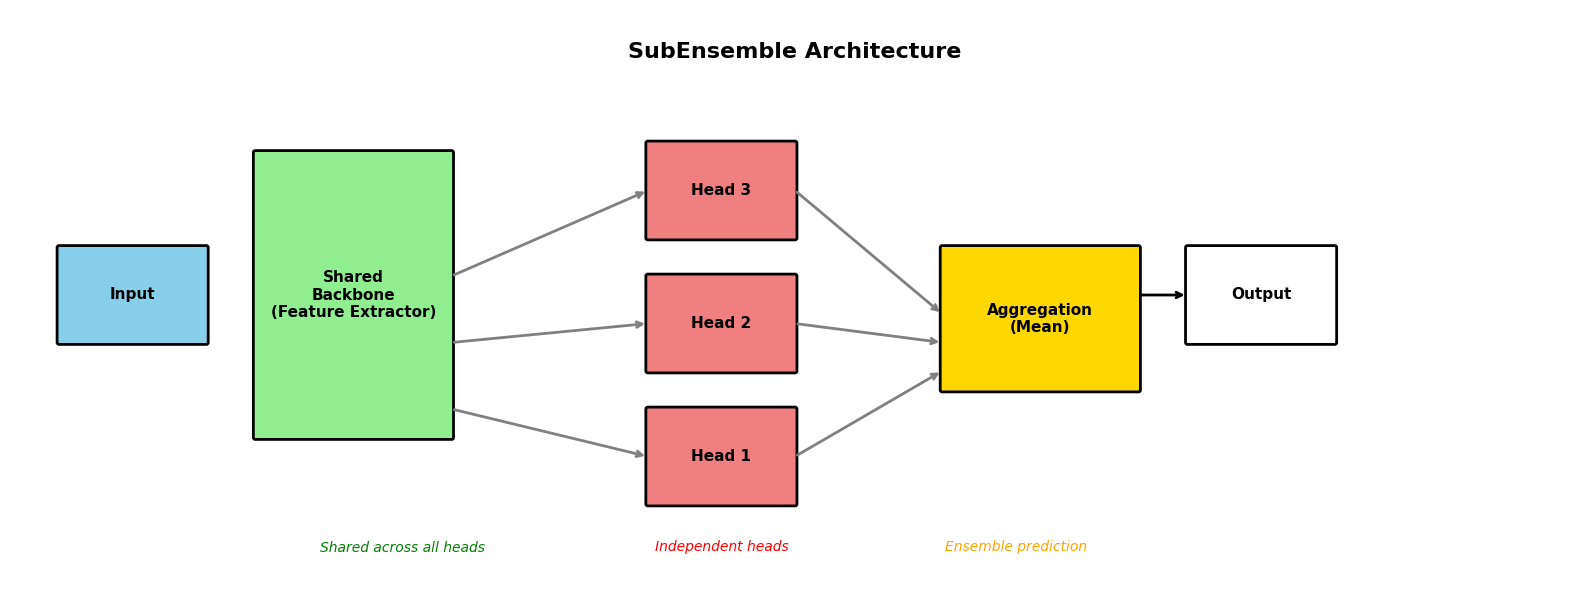

In [242]:
from matplotlib import patches

def visualize_subensemble_architecture():
    """Visualize the SubEnsemble architecture with shared backbone and multiple heads."""
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 6)
    ax.axis("off")
    
    def draw_block(x, y, width, height, text, color="lightblue"):
        rect = patches.FancyBboxPatch(
            (x, y), width, height, 
            boxstyle="round,pad=0.02", 
            edgecolor="black", 
            facecolor=color,
            linewidth=2
        )
        ax.add_patch(rect)
        ax.text(x + width / 2, y + height / 2, text, 
                ha="center", va="center", fontsize=11, fontweight="bold")
    
    def draw_arrow(x1, y1, x2, y2, color="black", width=2):
        ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                   arrowprops={"arrowstyle": "->", "lw": width, "color": color})
    

    ax.text(8, 5.5, "SubEnsemble Architecture", 
            fontsize=16, fontweight="bold", ha="center")
    
    draw_block(0.5, 2.5, 1.5, 1, "Input", color="skyblue")
    
    draw_block(2.5, 1.5, 2, 3, "Shared\nBackbone\n(Feature Extractor)", 
                color="lightgreen")
    
    head_y_positions = [0.8, 2.2, 3.6]
    head_colors = ["lightcoral", "lightcoral", "lightcoral"]
    
    for i, (y, color) in enumerate(zip(head_y_positions, head_colors)):
        draw_arrow(4.5, 2.5 + (i - 1) * 0.7, 6.5, y + 0.5, color="gray")
        draw_block(6.5, y, 1.5, 1, f"Head {i+1}", color=color)
        draw_arrow(8, y + 0.5, 9.5, 2.5 + (i - 1) * 0.3, color="gray")
    
    
    draw_block(9.5, 2, 2, 1.5, "Aggregation\n(Mean)", color="gold")
    
    
    draw_block(12, 2.5, 1.5, 1, "Output", color="white")
    draw_arrow(11.5, 3, 12, 3)
    
   
    ax.text(4, 0.3, "Shared across all heads", 
            fontsize=10, style="italic", ha="center", color="green")
    ax.text(7.25, 0.3, "Independent heads", 
            fontsize=10, style="italic", ha="center", color="red")
    ax.text(10.25, 0.3, "Ensemble prediction", 
            fontsize=10, style="italic", ha="center", color="orange")
    
    plt.tight_layout()
    plt.show()

visualize_subensemble_architecture()


## Splitting Strategies

We'll compare three different splitting strategies:

1. **Early Split**: Split after the first layer (minimal backbone)
2. **Balanced Split**: Split in the middle (balanced backbone/head)
3. **Late Split**: Split near the end (maximal backbone)

Let's visualize these strategies:


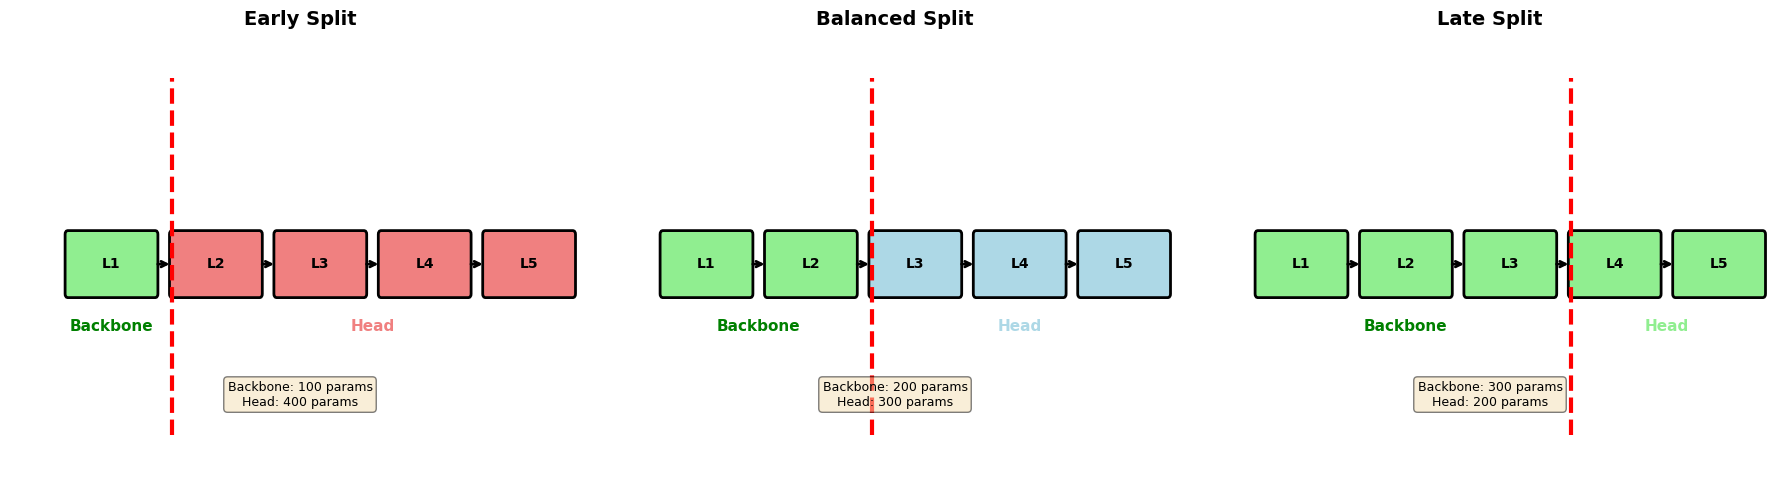

In [243]:
def visualize_splitting_strategies():
    """Visualize different splitting strategies."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    strategies = [
        ("Early Split", 1, "lightcoral"),
        ("Balanced Split", 2, "lightblue"),
        ("Late Split", 3, "lightgreen")
    ]
    
    for ax, (title, split_idx, color) in zip(axes, strategies):
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 6)
        ax.axis("off")
        ax.set_title(title, fontsize=14, fontweight="bold")
        
        num_layers = 5
        layer_width = 1.5
        layer_height = 0.8
        start_x = 1
        start_y = 2.5
        
        for i in range(split_idx):
            x = start_x + i * (layer_width + 0.3)
            rect = patches.FancyBboxPatch(
                (x, start_y), layer_width, layer_height,
                boxstyle="round,pad=0.05", edgecolor="black",
                facecolor="lightgreen", linewidth=2
            )
            ax.add_patch(rect)
            ax.text(x + layer_width/2, start_y + layer_height/2, 
                   f"L{i+1}", ha="center", va="center", fontweight="bold")
        
        for i in range(split_idx, num_layers):
            x = start_x + i * (layer_width + 0.3)
            rect = patches.FancyBboxPatch(
                (x, start_y), layer_width, layer_height,
                boxstyle="round,pad=0.05", edgecolor="black",
                facecolor=color, linewidth=2
            )
            ax.add_patch(rect)
            ax.text(x + layer_width/2, start_y + layer_height/2,
                   f"L{i+1}", ha="center", va="center", fontweight="bold")
        
        split_x = start_x + split_idx * (layer_width + 0.3)
        ax.axvline(split_x, ymin=0.1, ymax=0.9, 
                  color="red", linestyle="--", linewidth=3, label="Split Point")
        
        for i in range(num_layers - 1):
            x1 = start_x + i * (layer_width + 0.3) + layer_width
            x2 = start_x + (i + 1) * (layer_width + 0.3)
            ax.annotate("", xy=(x2, start_y + layer_height/2),
                       xytext=(x1, start_y + layer_height/2),
                       arrowprops={"arrowstyle": "->", "lw": 2, "color": "black"})
        
        backbone_x = start_x + (split_idx - 1) * (layer_width + 0.3) / 2 + layer_width / 2
        head_x = start_x + (split_idx + num_layers - 1) * (layer_width + 0.3) / 2 + layer_width / 2
        
        ax.text(backbone_x, start_y - 0.5, "Backbone", 
               ha="center", fontsize=11, fontweight="bold", color="green")
        ax.text(head_x, start_y - 0.5, "Head", 
               ha="center", fontsize=11, fontweight="bold", color=color)
        backbone_params = split_idx * 100  
        head_params = (num_layers - split_idx) * 100
        ax.text(5, 1, f"Backbone: {backbone_params} params\nHead: {head_params} params",
               ha="center", fontsize=9, bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
    
    plt.tight_layout()
    plt.show()

visualize_splitting_strategies()


In [244]:
class SubEnsemble(nn.Module):
    """SubEnsemble model with configurable backbone-head split point.
    
    This class splits a Sequential model into:
    - A shared backbone (feature extractor)
    - Multiple independent heads (prediction layers)
    """
    
    def __init__(
        self, 
        model: nn.Sequential, 
        n_heads: int = 3,
        split_point: int = -1
    ) -> None:
        """Initialize SubEnsemble.
        
        Args:
            model: Base Sequential model to split
            n_heads: Number of independent heads
            split_point: Index where to split (negative for counting from end)
                        -1 means split before last layer (default)
                        -2 means split before last 2 layers, etc.
        """
        super().__init__()
        
        self.n_heads = n_heads
        self.split_point = split_point
        
        if not isinstance(model, nn.Sequential):
            raise ValueError("Model must be nn.Sequential")
        
        if len(model) < 2:
            raise ValueError("Model must have at least 2 layers")
        
        
        if split_point < 0:
            split_point = len(model) + split_point
        
        if split_point < 1 or split_point >= len(model):
            raise ValueError(f"Split point {split_point} invalid for model with {len(model)} layers")
        
        self.backbone = nn.Sequential(*model[:split_point])
        head_template = nn.Sequential(*model[split_point:])
        
        # Create multiple independent heads 
        self.heads = generate_torch_ensemble(head_template, n_heads, reset_params=True)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through backbone and all heads.
        
        Args:
            x: Input tensor
            
        Returns:
            Averaged predictions from all heads
        """
       
        features = self.backbone(x)
        
       
        outputs = [head(features) for head in self.heads]
        
        return torch.stack(outputs).mean(dim=0)
    
    def forward_all_heads(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass returning predictions from all heads separately.
        
        Args:
            x: Input tensor
            
        Returns:
            Tensor of shape (batch_size, n_heads, n_classes) with predictions from each head
        """
        features = self.backbone(x)
        outputs = [head(features) for head in self.heads]
        return torch.stack(outputs, dim=1)  
    
    def count_parameters(self) -> dict[str, int]:
        """Count trainable parameters in backbone and heads.
        
        Returns:
            Dictionary with parameter counts
        """
        backbone_params = sum(p.numel() for p in self.backbone.parameters() if p.requires_grad)
        head_params = sum(p.numel() for p in self.heads[0].parameters() if p.requires_grad)
        total_head_params = head_params * self.n_heads
        total_params = backbone_params + total_head_params
        
        return {
            "backbone": backbone_params,
            "head_per_head": head_params,
            "head_total": total_head_params,
            "total": total_params
        }


## Implementation

The SubEnsemble class below demonstrates how to use **probly's transformation utilities** to create multiple independent heads from a shared backbone. Specifically, we use `generate_torch_ensemble` from `probly.transformation.ensemble.torch` to create multiple copies of the head layers with reset parameters, ensuring each head learns independently.


Let's create a simple test model and demonstrate the SubEnsemble with different split points:


In [245]:

def create_base_model(input_dim: int = 784, hidden_dims: list[int] = [256, 128, 64], 
                     output_dim: int = 10) -> nn.Sequential:
    """Create a simple feedforward neural network."""
    layers = []
    dims = [input_dim] + hidden_dims + [output_dim]
    
    for i in range(len(dims) - 1):
        layers.append(nn.Linear(dims[i], dims[i + 1]))
        if i < len(dims) - 2:  
            layers.append(nn.ReLU())
    
    return nn.Sequential(*layers)


base_model = create_base_model(input_dim=784, hidden_dims=[256, 128, 64], output_dim=10)


for split_point in [-1, -2, -3]:
    sub_ensemble = SubEnsemble(base_model, n_heads=3, split_point=split_point)
    params = sub_ensemble.count_parameters()
    
    print(f"\nSplit Point: {split_point} (split before last {abs(split_point)} layer(s))")
    print(f"  Backbone parameters: {params['backbone']:,}")
    print(f"  Head parameters (per head): {params['head_per_head']:,}")
    print(f"  Total head parameters: {params['head_total']:,}")
    print(f"  Total parameters: {params['total']:,}")
    print(f"  Parameter ratio (head/total): {params['head_total']/params['total']:.2%}")



Split Point: -1 (split before last 1 layer(s))
  Backbone parameters: 242,112
  Head parameters (per head): 650
  Total head parameters: 1,950
  Total parameters: 244,062
  Parameter ratio (head/total): 0.80%

Split Point: -2 (split before last 2 layer(s))
  Backbone parameters: 242,112
  Head parameters (per head): 650
  Total head parameters: 1,950
  Total parameters: 244,062
  Parameter ratio (head/total): 0.80%

Split Point: -3 (split before last 3 layer(s))
  Backbone parameters: 233,856
  Head parameters (per head): 8,906
  Total head parameters: 26,718
  Total parameters: 260,574
  Parameter ratio (head/total): 10.25%


## Experimental Setup

Now let's set up a comprehensive experiment to compare different splitting strategies. We'll use a synthetic dataset for controlled experiments:


In [246]:

def generate_synthetic_data(n_samples: int = 2000, n_features: int = 784, 
                           n_classes: int = 10, noise_level: float = 0.1):
    """Generate synthetic classification dataset."""
    X = torch.randn(n_samples, n_features)
    
    
    y = (X.sum(dim=1) > 0).long()
    for i in range(1, n_classes):
        mask = (X[:, i*10:(i+1)*10].sum(dim=1) > 0.5)
        y[mask] = i
    
    
    noise = torch.randn(n_samples, n_features) * noise_level
    X = X + noise
    
    return X, y


X_train, y_train = generate_synthetic_data(n_samples=2000, n_features=784, n_classes=10)
X_test, y_test = generate_synthetic_data(n_samples=500, n_features=784, n_classes=10)


batch_size = 64
train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    TensorDataset(X_test, y_test),
    batch_size=batch_size,
    shuffle=False
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")
print(f"Classes: {len(torch.unique(y_train))}")


Training samples: 2000
Test samples: 500
Features: 784
Classes: 10


Now let's create a comprehensive training and evaluation function:


In [247]:
def train_model(model: nn.Module, train_loader: DataLoader, 
                epochs: int = 10, lr: float = 0.001) -> dict[str, list[float]]:
    """Train a model and return training history."""
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    history = {"loss": [], "time": []}
    
    model.train()
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        n_batches = 0
        
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            n_batches += 1
        
        avg_loss = epoch_loss / n_batches
        history["loss"].append(avg_loss)
        history["time"].append(time.time() - start_time)
    
    return history

def evaluate_model(model: nn.Module, test_loader: DataLoader) -> dict[str, float]:
    """Evaluate model and return metrics."""
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_targets = []
    all_head_preds = []  
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model(batch_x)
            preds = outputs.argmax(dim=1)
            
            all_preds.append(preds.cpu())
            all_targets.append(batch_y.cpu())
            
            
            if isinstance(model, SubEnsemble):
                head_outputs = model.forward_all_heads(batch_x)
                all_head_preds.append(head_outputs.cpu())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    accuracy = (all_preds == all_targets).float().mean().item()
    
    
    diversity = 0.0
    if all_head_preds:
        head_preds = torch.cat(all_head_preds, dim=0)  
        probs = F.softmax(head_preds, dim=-1)
        entropies = -torch.sum(probs * torch.log(probs + 1e-8), dim=-1)  
        diversity = entropies.var(dim=1).mean().item()  
    
    return {
        "accuracy": accuracy,
        "diversity": diversity
    }

def count_parameters(model: nn.Module) -> int:
    """Count total trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [248]:

n_heads = 3
epochs = 15
split_points = [-1, -2, -3]  # Late, Balanced, Early

results = defaultdict(dict)

print("Running experiments with different split points...")


for split_point in split_points:
    print(f"\nSplit Point: {split_point}")
    print("-" * 70)
    
    
    base_model = create_base_model(input_dim=784, hidden_dims=[256, 128, 64], output_dim=10)
    

    model = SubEnsemble(base_model, n_heads=n_heads, split_point=split_point)
    
   
    param_info = model.count_parameters()
    results[split_point]["params"] = param_info
    
  
    print("Training...")
    train_start = time.time()
    train_history = train_model(model, train_loader, epochs=epochs, lr=0.001)
    train_time = time.time() - train_start
    
    results[split_point]["train_time"] = train_time
    results[split_point]["train_history"] = train_history
    
   
    print("Evaluating...")
    eval_results = evaluate_model(model, test_loader)
    results[split_point]["accuracy"] = eval_results["accuracy"]
    results[split_point]["diversity"] = eval_results["diversity"]
    
    print(f"  Total parameters: {param_info['total']:,}")
    print(f"  Backbone parameters: {param_info['backbone']:,} ({param_info['backbone']/param_info['total']:.1%})")
    print(f"  Head parameters: {param_info['head_total']:,} ({param_info['head_total']/param_info['total']:.1%})")
    print(f"  Training time: {train_time:.2f}s")
    print(f"  Test accuracy: {eval_results['accuracy']:.4f}")
    print(f"  Head diversity: {eval_results['diversity']:.4f}")

print("\n" + "="*70)
print("Experiments completed!")


Running experiments with different split points...

Split Point: -1
----------------------------------------------------------------------
Training...
Evaluating...
  Total parameters: 244,062
  Backbone parameters: 242,112 (99.2%)
  Head parameters: 1,950 (0.8%)
  Training time: 0.64s
  Test accuracy: 0.5380
  Head diversity: 0.0788

Split Point: -2
----------------------------------------------------------------------
Training...
Evaluating...
  Total parameters: 244,062
  Backbone parameters: 242,112 (99.2%)
  Head parameters: 1,950 (0.8%)
  Training time: 0.67s
  Test accuracy: 0.5120
  Head diversity: 0.0915

Split Point: -3
----------------------------------------------------------------------
Training...
Evaluating...
  Total parameters: 260,574
  Backbone parameters: 233,856 (89.7%)
  Head parameters: 26,718 (10.3%)
  Training time: 0.67s
  Test accuracy: 0.5680
  Head diversity: 0.0596

Experiments completed!


## Results and Analysis

Let's visualize and analyze the results:


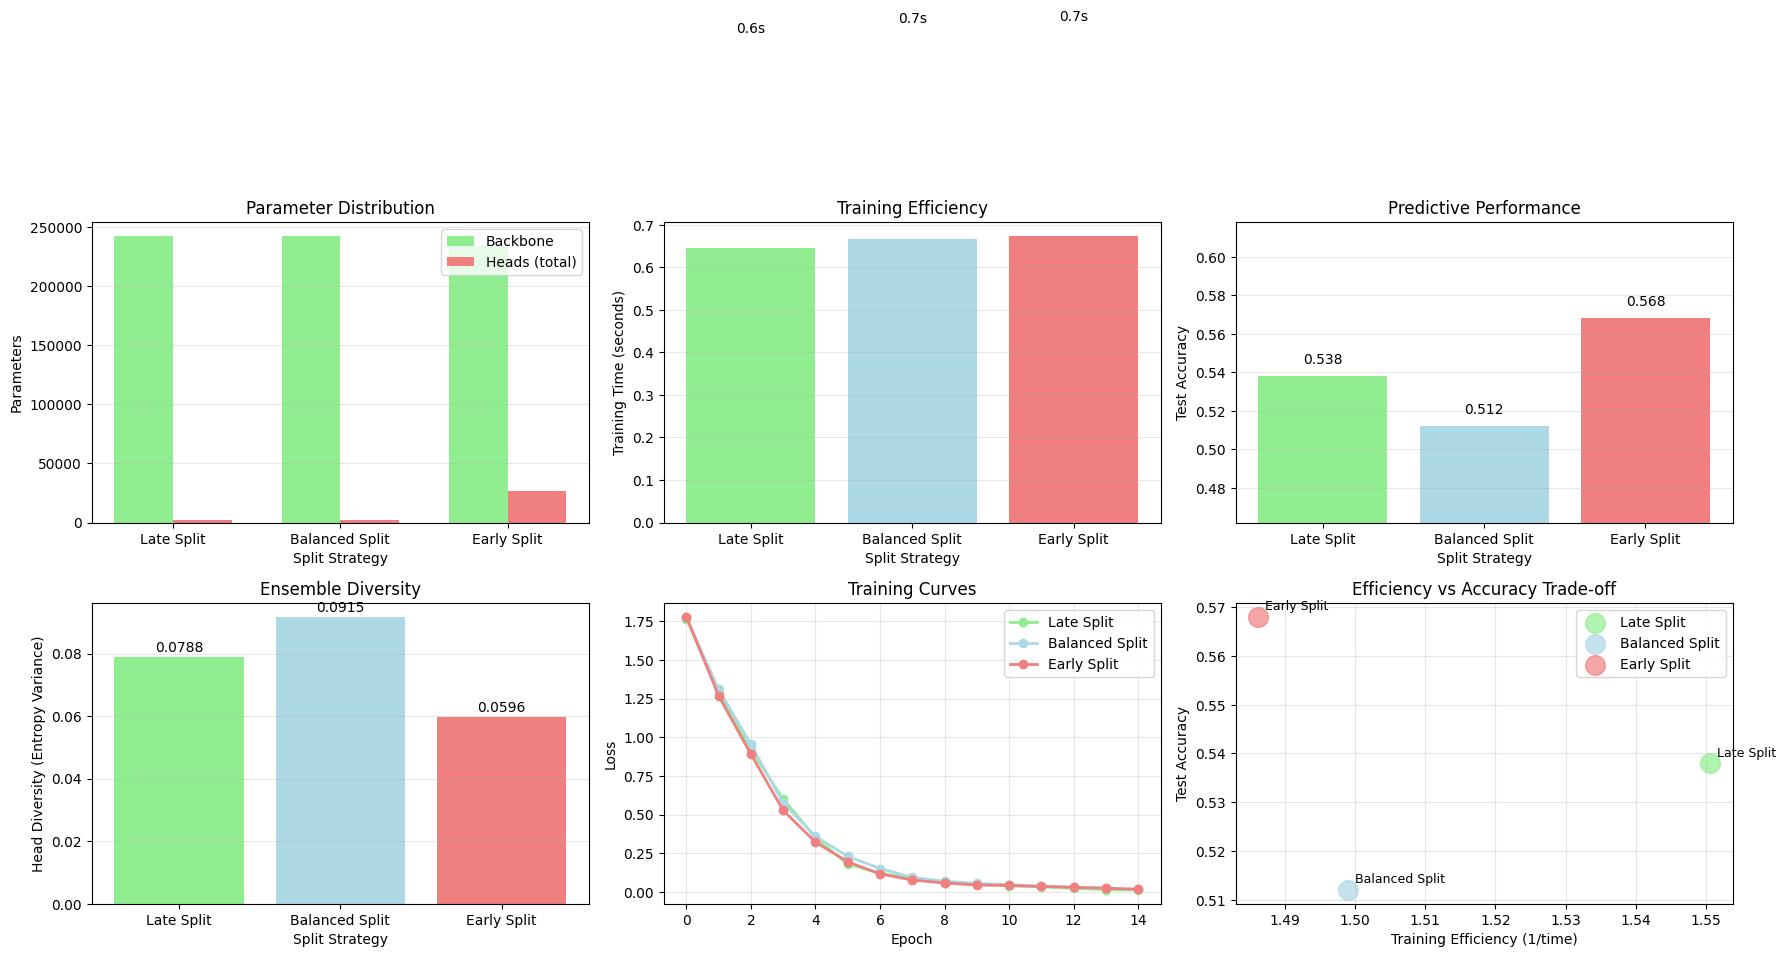

In [249]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

split_labels = {-1: "Late Split", -2: "Balanced Split", -3: "Early Split"}
colors = {-1: "lightgreen", -2: "lightblue", -3: "lightcoral"}

# 1. Parameter Comparison
ax = axes[0, 0]
split_points_list = list(results.keys())
backbone_params = [results[sp]["params"]["backbone"] for sp in split_points_list]
head_params = [results[sp]["params"]["head_total"] for sp in split_points_list]
total_params = [results[sp]["params"]["total"] for sp in split_points_list]

x = np.arange(len(split_points_list))
width = 0.35

ax.bar(x - width/2, backbone_params, width, label="Backbone", color="lightgreen")
ax.bar(x + width/2, head_params, width, label="Heads (total)", color="lightcoral")
ax.set_xlabel("Split Strategy")
ax.set_ylabel("Parameters")
ax.set_title("Parameter Distribution")
ax.set_xticks(x)
ax.set_xticklabels([split_labels[sp] for sp in split_points_list])
ax.legend()
ax.grid(axis="y", alpha=0.3)

# 2. Training Time
ax = axes[0, 1]
train_times = [results[sp]["train_time"] for sp in split_points_list]
bars = ax.bar(range(len(split_points_list)), train_times, 
              color=[colors[sp] for sp in split_points_list])
ax.set_xlabel("Split Strategy")
ax.set_ylabel("Training Time (seconds)")
ax.set_title("Training Efficiency")
ax.set_xticks(range(len(split_points_list)))
ax.set_xticklabels([split_labels[sp] for sp in split_points_list])
ax.grid(axis="y", alpha=0.3)
for i, (bar, time) in enumerate(zip(bars, train_times)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f"{time:.1f}s", ha="center", va="bottom")

# 3. Accuracy Comparison
ax = axes[0, 2]
accuracies = [results[sp]["accuracy"] for sp in split_points_list]
bars = ax.bar(range(len(split_points_list)), accuracies,
              color=[colors[sp] for sp in split_points_list])
ax.set_xlabel("Split Strategy")
ax.set_ylabel("Test Accuracy")
ax.set_title("Predictive Performance")
ax.set_xticks(range(len(split_points_list)))
ax.set_xticklabels([split_labels[sp] for sp in split_points_list])
ax.set_ylim([min(accuracies) - 0.05, max(accuracies) + 0.05])
ax.grid(axis="y", alpha=0.3)
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f"{acc:.3f}", ha="center", va="bottom")

# 4. Head Diversity
ax = axes[1, 0]
diversities = [results[sp]["diversity"] for sp in split_points_list]
bars = ax.bar(range(len(split_points_list)), diversities,
              color=[colors[sp] for sp in split_points_list])
ax.set_xlabel("Split Strategy")
ax.set_ylabel("Head Diversity (Entropy Variance)")
ax.set_title("Ensemble Diversity")
ax.set_xticks(range(len(split_points_list)))
ax.set_xticklabels([split_labels[sp] for sp in split_points_list])
ax.grid(axis="y", alpha=0.3)
for i, (bar, div) in enumerate(zip(bars, diversities)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
            f"{div:.4f}", ha="center", va="bottom")

#5. Training Curves
ax = axes[1, 1]
for sp in split_points_list:
    history = results[sp]["train_history"]
    ax.plot(history["loss"], label=split_labels[sp], 
           color=colors[sp], linewidth=2, marker="o")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Curves")
ax.legend()
ax.grid(alpha=0.3)

#6. Efficiency vs Accuracy Trade-off
ax = axes[1, 2]
for sp in split_points_list:
    efficiency = 1 / results[sp]["train_time"]  # Inverse of time = efficiency
    accuracy = results[sp]["accuracy"]
    ax.scatter(efficiency, accuracy, s=200, 
              color=colors[sp], label=split_labels[sp], alpha=0.7)
    ax.annotate(split_labels[sp], (efficiency, accuracy),
               xytext=(5, 5), textcoords="offset points", fontsize=9)

ax.set_xlabel("Training Efficiency (1/time)")
ax.set_ylabel("Test Accuracy")
ax.set_title("Efficiency vs Accuracy Trade-off")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Key Observations

Let's analyze the key findings from our experiments:


In [250]:

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

# 1. Parameter efficiency
print("\n1. PARAMETER EFFICIENCY:")
for sp in split_points:
    params = results[sp]["params"]
    backbone_ratio = params["backbone"] / params["total"]
    print(f"  {split_labels[sp]}: {backbone_ratio:.1%} backbone, {1-backbone_ratio:.1%} heads")

# 2. Training efficiency
print("\n2. TRAINING EFFICIENCY:")
fastest = min(split_points, key=lambda sp: results[sp]["train_time"])
slowest = max(split_points, key=lambda sp: results[sp]["train_time"])
print(f"  Fastest: {split_labels[fastest]} ({results[fastest]['train_time']:.2f}s)")
print(f"  Slowest: {split_labels[slowest]} ({results[slowest]['train_time']:.2f}s)")
print(f"  Speedup: {results[slowest]['train_time']/results[fastest]['train_time']:.2f}x")

# 3. Accuracy comparison
print("\n3. ACCURACY:")
best_acc = max(split_points, key=lambda sp: results[sp]["accuracy"])
worst_acc = min(split_points, key=lambda sp: results[sp]["accuracy"])
print(f"  Best: {split_labels[best_acc]} ({results[best_acc]['accuracy']:.4f})")
print(f"  Worst: {split_labels[worst_acc]} ({results[worst_acc]['accuracy']:.4f})")
print(f"  Difference: {results[best_acc]['accuracy'] - results[worst_acc]['accuracy']:.4f}")

# 4. Diversity
print("\n4. HEAD DIVERSITY:")
most_diverse = max(split_points, key=lambda sp: results[sp]["diversity"])
least_diverse = min(split_points, key=lambda sp: results[sp]["diversity"])
print(f"  Most diverse: {split_labels[most_diverse]} ({results[most_diverse]['diversity']:.4f})")
print(f"  Least diverse: {split_labels[least_diverse]} ({results[least_diverse]['diversity']:.4f})")

# 5. Best overall
print("\n5. OVERALL ASSESSMENT:")
scores = {}
for sp in split_points:
    norm_time = 1 - (results[sp]["train_time"] - min(r["train_time"] for r in results.values())) / \
                (max(r["train_time"] for r in results.values()) - min(r["train_time"] for r in results.values()) + 1e-8)
    norm_acc = (results[sp]["accuracy"] - min(r["accuracy"] for r in results.values())) / \
               (max(r["accuracy"] for r in results.values()) - min(r["accuracy"] for r in results.values()) + 1e-8)
    norm_div = (results[sp]["diversity"] - min(r["diversity"] for r in results.values())) / \
               (max(r["diversity"] for r in results.values()) - min(r["diversity"] for r in results.values()) + 1e-8)
    

    composite = 0.3 * norm_time + 0.5 * norm_acc + 0.2 * norm_div
    scores[sp] = composite

best_overall = max(split_points, key=lambda sp: scores[sp])
print(f"  Best overall (composite score): {split_labels[best_overall]} ({scores[best_overall]:.3f})")



KEY INSIGHTS

1. PARAMETER EFFICIENCY:
  Late Split: 99.2% backbone, 0.8% heads
  Balanced Split: 99.2% backbone, 0.8% heads
  Early Split: 89.7% backbone, 10.3% heads

2. TRAINING EFFICIENCY:
  Fastest: Late Split (0.64s)
  Slowest: Early Split (0.67s)
  Speedup: 1.04x

3. ACCURACY:
  Best: Early Split (0.5680)
  Worst: Balanced Split (0.5120)
  Difference: 0.0560

4. HEAD DIVERSITY:
  Most diverse: Balanced Split (0.0915)
  Least diverse: Early Split (0.0596)

5. OVERALL ASSESSMENT:
  Best overall (composite score): Late Split (0.652)


## Practical Guidelines


Based on our experiments, here are practical guidelines for choosing split points:


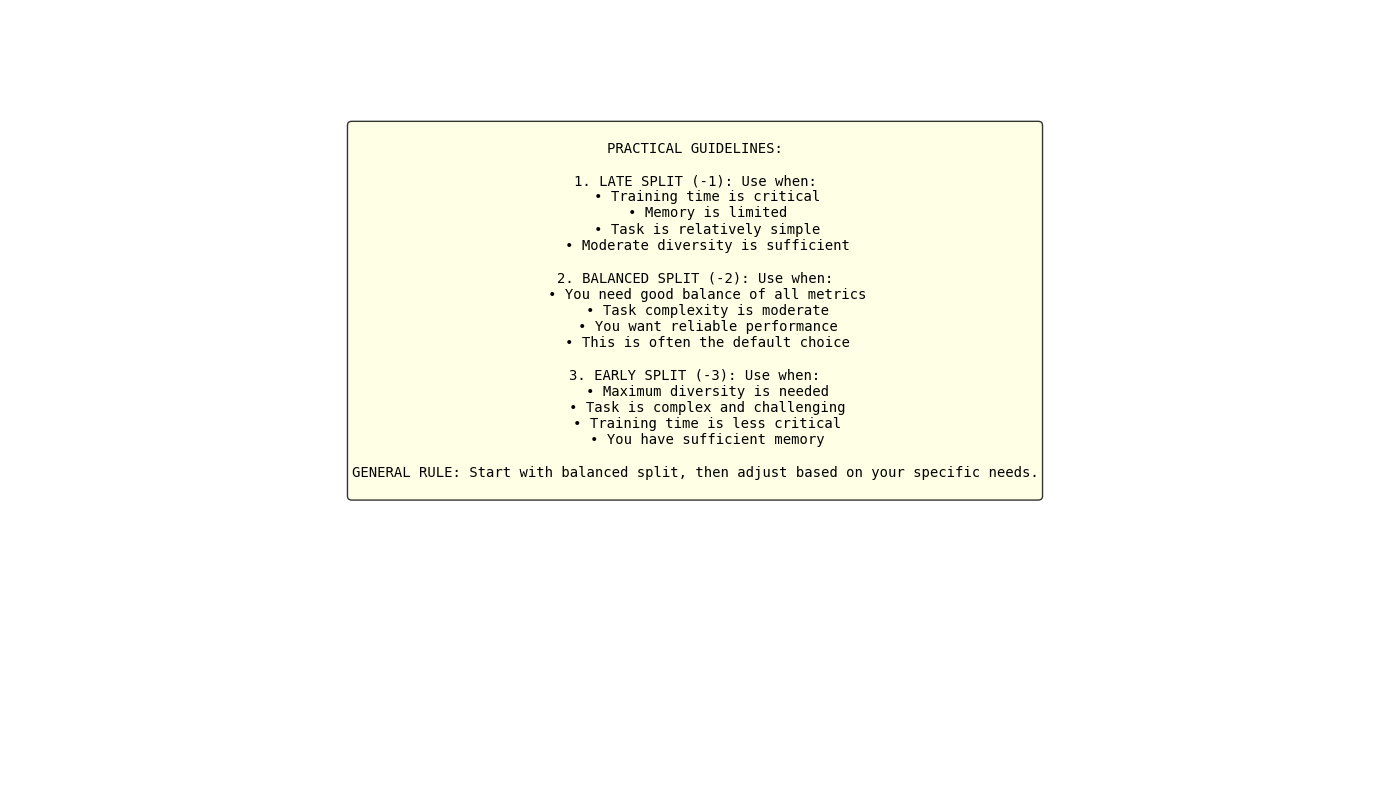

In [251]:

fig, ax = plt.subplots(figsize=(14, 8))
ax.axis("off")


y_start = 0.9
x_center = 0.5
box_width = 0.15
box_height = 0.08
arrow_length = 0.012



guidelines_text = """
PRACTICAL GUIDELINES:

1. LATE SPLIT (-1): Use when:
   • Training time is critical
   • Memory is limited
   • Task is relatively simple
   • Moderate diversity is sufficient

2. BALANCED SPLIT (-2): Use when:
   • You need good balance of all metrics
   • Task complexity is moderate
   • You want reliable performance
   • This is often the default choice

3. EARLY SPLIT (-3): Use when:
   • Maximum diversity is needed
   • Task is complex and challenging
   • Training time is less critical
   • You have sufficient memory

GENERAL RULE: Start with balanced split, then adjust based on your specific needs.
"""

ax.text(0.5, 0.85, guidelines_text, ha="center", va="top",
       fontsize=10, bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.8),
       family="monospace")

plt.tight_layout()
plt.show()


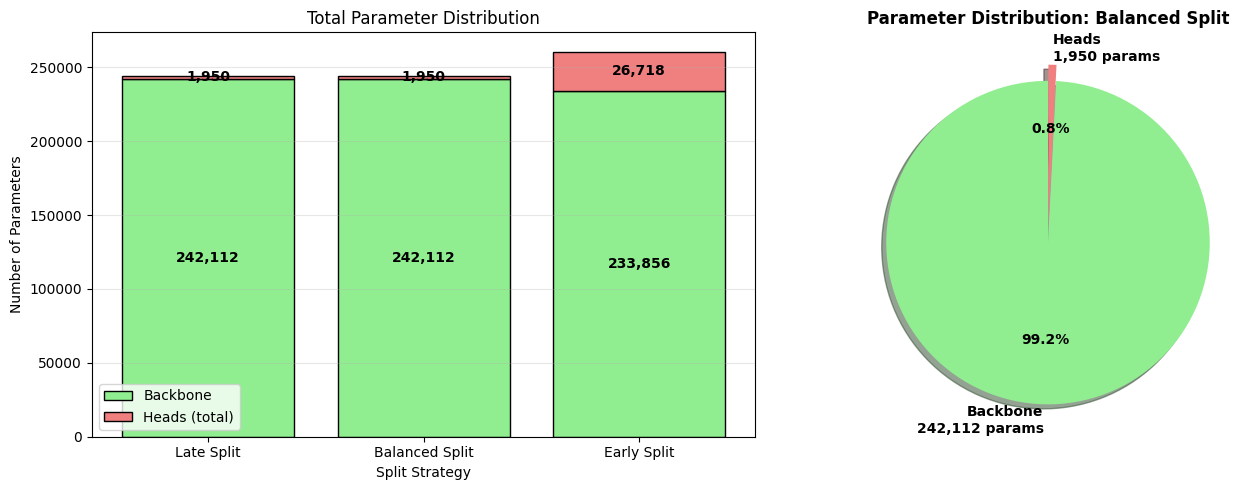


Parameter Efficiency Analysis:

Late Split:
  Backbone: 99.2% of total parameters
  Heads: 0.8% of total parameters
  Parameter efficiency: 99.2% shared, 0.8% duplicated

Balanced Split:
  Backbone: 99.2% of total parameters
  Heads: 0.8% of total parameters
  Parameter efficiency: 99.2% shared, 0.8% duplicated

Early Split:
  Backbone: 89.7% of total parameters
  Heads: 10.3% of total parameters
  Parameter efficiency: 89.7% shared, 10.3% duplicated


In [252]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


split_points_list = list(results.keys())
backbone_params = [results[sp]["params"]["backbone"] for sp in split_points_list]
head_params = [results[sp]["params"]["head_total"] for sp in split_points_list]

x = np.arange(len(split_points_list))
ax1.bar(x, backbone_params, label="Backbone", color="lightgreen", edgecolor="black")
ax1.bar(x, head_params, bottom=backbone_params, label="Heads (total)", 
       color="lightcoral", edgecolor="black")
ax1.set_xlabel("Split Strategy")
ax1.set_ylabel("Number of Parameters")
ax1.set_title("Total Parameter Distribution")
ax1.set_xticks(x)
ax1.set_xticklabels([split_labels[sp] for sp in split_points_list])
ax1.legend()
ax1.grid(axis="y", alpha=0.3)


for i, (bp, hp) in enumerate(zip(backbone_params, head_params)):
    ax1.text(i, bp/2, f"{bp:,}", ha="center", va="center", fontweight="bold")
    ax1.text(i, bp + hp/2, f"{hp:,}", ha="center", va="center", fontweight="bold")

sp = -2
params = results[sp]["params"]
sizes = [params["backbone"], params["head_total"]]
labels = [f"Backbone\n{params['backbone']:,} params", 
         f"Heads\n{params['head_total']:,} params"]
colors_pie = ["lightgreen", "lightcoral"]
explode = (0.05, 0.05)

ax2.pie(sizes, explode=explode, labels=labels, colors=colors_pie,
       autopct=lambda pct: f"{pct:.1f}%", shadow=True, startangle=90,
       textprops={"fontsize": 10, "fontweight": "bold"})
ax2.set_title(f"Parameter Distribution: {split_labels[sp]}", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()


print("\nParameter Efficiency Analysis:")
print("="*70)
for sp in split_points:
    params = results[sp]["params"]
    backbone_pct = params["backbone"] / params["total"] * 100
    head_pct = params["head_total"] / params["total"] * 100
    print(f"\n{split_labels[sp]}:")
    print(f"  Backbone: {backbone_pct:.1f}% of total parameters")
    print(f"  Heads: {head_pct:.1f}% of total parameters")
    print(f"  Parameter efficiency: {backbone_pct:.1f}% shared, {head_pct:.1f}% duplicated")


---

**Note**: This notebook demonstrates the concepts and trade-offs involved in backbone-head splitting for SubEnsemble architectures. In practice, the optimal split point will depend on your specific dataset, model architecture, and computational constraints. Always experiment with different configurations to find what works best for your use case.
